<a href="https://colab.research.google.com/github/LSJgobsl/TransformerSNP500/blob/develop/snp500_20210120.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from IPython.display import display
from IPython.display import SVG, Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
raw_data = pd.read_csv('./drive/MyDrive/graph/GSPC_5y.csv')
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data.set_index('Date',inplace=True)

goog = pd.read_csv('./drive/MyDrive/graph/GOOG.csv')
goog['Date'] = pd.to_datetime(goog['Date'])
goog.set_index('Date',inplace = True)

amzn = pd.read_csv('./drive/MyDrive/graph/AMZN.csv')
amzn['Date'] = pd.to_datetime(amzn['Date'])
amzn.set_index('Date',inplace=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


volume = 주식 거래량 \
open = 장 시작\
close = 장 마감\
high = 장중 최고거래액\
low = 장중 최저거래액

전체 데이터 shape:(1259, 6)


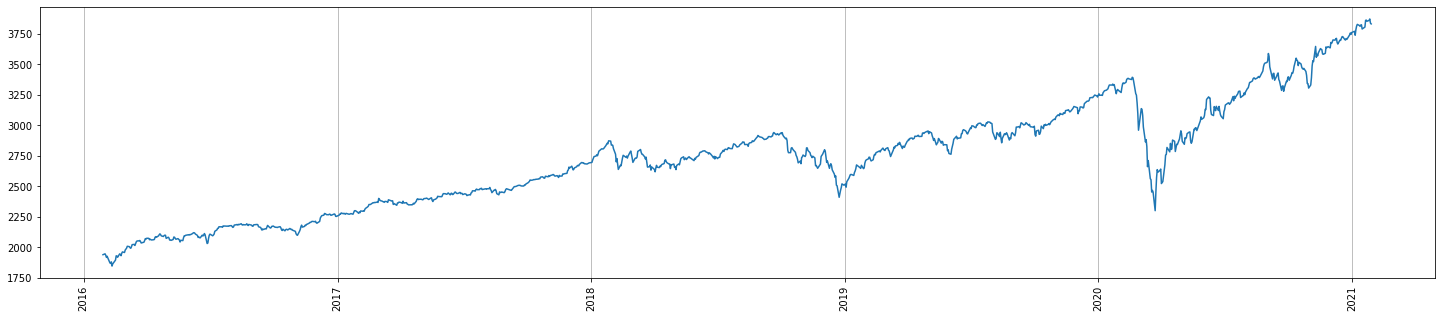

In [ ]:
print("전체 데이터 shape:{}".format(raw_data.shape))
plt.figure(figsize=(25,5))
plt.plot(raw_data['High'])
plt.xticks(rotation=90)
plt.grid(axis='x')

In [ ]:
output_window = 1
input_window = 28
batch_size = 7

merged_data
                    GSPC         AMZN        GOOGL
Date                                             
2016-01-29  1940.239990   593.000000   744.989990
2016-02-01  1947.199951   581.799988   757.859985
2016-02-02  1935.260010   571.559998   789.869995
2016-02-03  1918.010010   556.000000   774.500000
2016-02-04  1927.349976   538.989990   727.000000
...                 ...          ...          ...
2021-01-22  3852.310059  3321.909912  1910.949951
2021-01-25  3859.229980  3363.889893  1929.579956
2021-01-26  3870.899902  3338.000000  1925.000000
2021-01-27  3836.830078  3346.520020  1890.000000
2021-01-28  3830.500000  3301.594971  1898.829956

[1259 rows x 3 columns]
(1259, 1)
[[-1.79138861 -4.86799753 -4.52090736]
 [-1.77549458 -4.89357431 -4.49151695]
 [-1.80276109 -4.91695874 -4.41841766]
 ...
 [ 2.61754042  1.40058976 -1.82619124]
 [ 2.53973726  1.42004641 -1.90611858]
 [ 2.52528165  1.31745384 -1.88595416]]
train set :  (882,)
(882, 3)


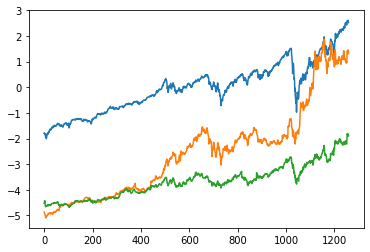

In [ ]:
X_cols = list(raw_data.columns)
X_cols.remove('High')

test_data_size = int(1258*0.3)
X = raw_data[X_cols]
y = raw_data['High']
y.dropna(inplace=True)
#print(y)

goog_high = goog['High']
goog_high.dropna(inplace=True)
#print(goog_high)

amzn_high = amzn['High']
amzn_high.dropna(inplace=True)
#print(amzn_high)

merged_data = pd.merge(y,amzn_high,on='Date')
merged_data = pd.merge(merged_data, goog_high, on='Date')

merged_data = merged_data.rename(columns={'High_x': 'GSPC', 'High_y':'AMZN', 'High':'GOOGL'})
print('merged_data\n',merged_data)

scaler = StandardScaler()
mdscaler = scaler.fit(merged_data)
yscaler = scaler.fit(y.values.reshape(-1,1))


y = yscaler.transform(y.values.reshape(-1,1))
print(y.shape)



md = mdscaler.transform(merged_data)
print(md)

X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()
md_train, md_test = md[:-test_data_size], md[-test_data_size:]

print("train set : ",(y_train.shape))
print(md_train.shape)

plt.plot(md)

#y_train

#**seq data 형성함수**
>create sequence 시퀀스를 생성한다 \
 그리고 sequence로 바꾼다.

In [ ]:
mdl = input("사용 Model\n 1:Transformer 2:LSTM: ")
mdl = int(mdl)

사용 Model
 1:Transformer 2:LSTM: 2


In [ ]:
def create_sequences1(array, tw):
  res = []
  L = len(array)
  for i in range(L - tw ):
    #print(len(array[i:i+tw]))
    tr_seq = array[i:i + tw]
    #print(tr_seq)
    train_label = array[i+output_window:i+output_window + tw]
    res.append((tr_seq, train_label))
  return torch.FloatTensor(res)

In [ ]:
def create_sequences2(array,array2, tw):
  input = []
  output = []

  for i in range(len(array)-tw-1):
    tmp = array[i:i+tw]
    input.append(tmp)
    tmp2 = array2[i+1: i+1+tw]
    output.append(tmp2)
  
  return torch.FloatTensor(input), torch.FloatTensor(output)

In [ ]:
seq_len = input_window
#X_train = create_sequences1(X_train, seq_len)
y_train_seq = create_sequences1(y_train, seq_len)
#X_test = create_sequences1(X_test, seq_len)
y_test_seq = create_sequences1(y_test, seq_len)

md_train_seq = create_sequences1(md_train, input_window)
md_test_seq = create_sequences1(md_test, input_window)

lstm_md_train, lstm_tgt_train= create_sequences2(md_train,y_train,input_window)
lstm_md_test, lstm_tgt_test = create_sequences2(md_test, y_test, input_window)

tf_input_train, tf_output_train = create_sequences2(md_train,y_train,input_window)
tf_input_test, tf_output_test = create_sequences2(md_test, y_test, input_window)

y_train_seq = y_train_seq[:-output_window]
y_test_seq = y_test_seq[:-output_window]
print(y_train_seq.shape)
print(md_train_seq.shape)
print(lstm_md_test.shape)
print(lstm_tgt_test.shape)


torch.Size([853, 2, 28])
torch.Size([854, 2, 28, 3])
torch.Size([348, 28, 3])
torch.Size([348, 28])


In [ ]:
lstm_md_test

tensor([[[ 0.6598, -1.8880, -3.4039],
         [ 0.5043, -2.0058, -3.4661],
         [ 0.3959, -2.1375, -3.5384],
         ...,
         [ 0.5945, -2.0188, -3.4544],
         [ 0.6046, -1.9975, -3.4362],
         [ 0.5817, -2.0527, -3.4590]],

        [[ 0.5043, -2.0058, -3.4661],
         [ 0.3959, -2.1375, -3.5384],
         [ 0.3647, -2.1259, -3.5276],
         ...,
         [ 0.6046, -1.9975, -3.4362],
         [ 0.5817, -2.0527, -3.4590],
         [ 0.6308, -2.0353, -3.4302]],

        [[ 0.3959, -2.1375, -3.5384],
         [ 0.3647, -2.1259, -3.5276],
         [ 0.3825, -2.1141, -3.5311],
         ...,
         [ 0.5817, -2.0527, -3.4590],
         [ 0.6308, -2.0353, -3.4302],
         [ 0.6761, -1.9891, -3.3862]],

        ...,

        [[ 2.1494,  0.8997, -2.1472],
         [ 2.2218,  1.0637, -2.1176],
         [ 2.2165,  1.0592, -2.1769],
         ...,
         [ 2.5921,  1.2677, -1.8748],
         [ 2.5960,  1.4247, -1.8037],
         [ 2.5751,  1.3638, -1.8583]],

        [[

>예시


예시의 create_inout_sequences 역할과 비슷

In [ ]:
#print("X_train :",(X_train.shape))
#print("X_test :",(X_test.shape))
#print("y_train :",(y_train_seq.shape))
#print("y_test :",(y_test_seq.shape))

**LSTM**

In [ ]:
class LSTMModel(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(LSTMModel, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(input_size = n_features,
                        hidden_size = n_hidden,
                        num_layers = n_layers,
                        dropout = 0.1)
    
    self.linear = nn.Linear(in_features=n_hidden, out_features = 1)

  def reset_hidden_state(self):
    self.hidden = (torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device),
                   torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device))
    
  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(sequences.view(len(sequences),self.seq_len,-1),self.hidden)
    last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)

    return y_pred


In [ ]:
model = LSTMModel(3,2,7)
print(model)

LSTMModel(
  (lstm): LSTM(3, 2, num_layers=2, dropout=0.1)
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


**MODEL 정의하기**
**Transformer**

In [ ]:
class TransformerModel(nn.Module):

  def __init__(self, ninp = 256, nlayers=1, dropout=0.5):
    super(TransformerModel, self).__init__()

    from torch.nn import TransformerEncoder, TransformerEncoderLayer
    
    self.model_type = 'Transformer'
    
    self.src_mask = None
    
    self.ninp = ninp
    self.encoder = nn.Linear(3,ninp)
    self.pos_encoder = PositionalEncoding(ninp)
    self.encoder_layers = TransformerEncoderLayer(d_model = ninp, nhead = 8, dropout = dropout)
    self.transformer_encoder = TransformerEncoder(self.encoder_layers, num_layers = nlayers)
   # self.encoder = nn.Embedding(1, ninp) #시계열에서 불필요?
    self.decoder = nn.Linear(ninp, 1)

    self.init_weights()

  def _generate_square_subsequent_mask(self, sz):
    mask = (torch.triu(torch.ones(sz,sz))==1).transpose(0,1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

  def init_weights(self):
    initrange = 0.1
    #self.encoder.weight.data.uniform_(-initrange,initrange)
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform_(-initrange, initrange)

  def forward(self, src):
    if self.src_mask is None or self.src_mask.size(0) != len(src):
      device = src.device
      mask = self._generate_square_subsequent_mask(len(src)).to(device)
      self.src_mask = mask

    src = self.encoder(src)*math.sqrt(self.ninp)
    src = self.pos_encoder(src)
    output = self.transformer_encoder(src, self.src_mask)
    output = self.decoder(output)
    return output

**Positional Encoing**


In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout = 0.5, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)


    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0,1)
    self.register_buffer('pe',pe)
  
  def forward(self,x):
    x = x + self.pe[:x.size(0), :]
    return self.dropout(x)

In [ ]:
'''
model = TransformerModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
'''

'\nmodel = TransformerModel()\nloss_function = nn.MSELoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=0.001)\n'


**트랜스포머 모델 프린트**
```
# 코드로 형식 지정됨
TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder_layers): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=2048, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=256, out_features=1, bias=True)
)
```



In [ ]:
def get_batch(source, i, batch_size):
  length = min(batch_size, len(source) - 1 - i)
  data = source[i:i+length]
  input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) #1은 feature size
  target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
  #input = data
  #target = source[i+1:i+1+length].view(-1)
  return input, target

In [ ]:
a,b = get_batch(y_train_seq, 0, batch_size)
print(b.shape,'\n', a.shape)
#print(tf_output_train.view(-1,input_window,1))
print(tf_output_train)
a


torch.Size([28, 7, 1]) 
 torch.Size([28, 7, 1])
tensor([[-1.7755, -1.8028, -1.8422,  ..., -1.6620, -1.6716, -1.6433],
        [-1.8028, -1.8422, -1.8208,  ..., -1.6716, -1.6433, -1.6038],
        [-1.8422, -1.8208, -1.8534,  ..., -1.6433, -1.6038, -1.5988],
        ...,
        [ 0.4707,  0.4728,  0.5329,  ...,  0.6735,  0.6660,  0.6926],
        [ 0.4728,  0.5329,  0.5469,  ...,  0.6660,  0.6926,  0.6872],
        [ 0.5329,  0.5469,  0.5258,  ...,  0.6926,  0.6872,  0.6680]])


tensor([[[-1.7914],
         [-1.7755],
         [-1.8028],
         [-1.8422],
         [-1.8208],
         [-1.8534],
         [-1.9444]],

        [[-1.7755],
         [-1.8028],
         [-1.8422],
         [-1.8208],
         [-1.8534],
         [-1.9444],
         [-1.9558]],

        [[-1.8028],
         [-1.8422],
         [-1.8208],
         [-1.8534],
         [-1.9444],
         [-1.9558],
         [-1.9253]],

        [[-1.8422],
         [-1.8208],
         [-1.8534],
         [-1.9444],
         [-1.9558],
         [-1.9253],
         [-2.0043]],

        [[-1.8208],
         [-1.8534],
         [-1.9444],
         [-1.9558],
         [-1.9253],
         [-2.0043],
         [-1.9637]],

        [[-1.8534],
         [-1.9444],
         [-1.9558],
         [-1.9253],
         [-2.0043],
         [-1.9637],
         [-1.8929]],

        [[-1.9444],
         [-1.9558],
         [-1.9253],
         [-2.0043],
         [-1.9637],
         [-1.8929],
         [-1.8132]],

      

#**Train 생성하기**


In [ ]:
import os
def createDirectory(directory):
  try:
    if not os.path.exists(directory):
      os.makedirs(directory)
  except OSError:
    print("failed")

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

In [ ]:

def MPE(test, pred):

  #test, pred = check_array

  return torch.mean((test - pred) / test)*100

In [ ]:
def plot_and_loss(eval_model, data_source, data_output, epoch):
  preds = []
  data = input
  total_loss = 0.
  with torch.no_grad():
    for i in range(0,len(data_source) - 1):
      test_seq = data_source[i:i+1]
      y_test_pred = eval_model(test_seq)
      #print(y_test_pred[0][99].shape, data_output[:,[-1]].shape)
      pred = torch.flatten(y_test_pred[0][-1]).item()
      preds.append(pred)

      

      #total_loss+= criterion(y_test_pred.view(-1, input_window), targets).cpu().item()
      new_seq = test_seq.cpu().numpy().flatten()
      new_seq = np.append(new_seq, pred)
      new_seq = new_seq[1:]
      test_seq = torch.as_tensor(new_seq).view(3, input_window, 1).float()

  ''' 
  print("R^2 score:", r2_score(truth, test_result))
  print("MSE score:", mse(truth, test_result))
  print("RMSE SCORE:",np.sqrt(mse(truth, test_result)))
  print("MPE SCORE:", MPE(truth, test_result))
  '''
  plt.autoscale(axis = 'x', tight = True)
  plt.plot(preds, color = 'red')
  plt.plot(data_output.cpu()[:,[-1]])
  plt.savefig('./drive/MyDrive/graph/Per10/tf-scaled%d.png'%(epoch))
  plt.close()

  return total_loss / i

In [ ]:

def evaluate(eval_model, data_source, data_output):
  eval_model.eval()
  total_loss = 0.
  eval_batch_size = 1000
  with torch.no_grad():
    for i in range(0, len(data_source) - 1, eval_batch_size):
      data, targets = data_source, data_output
      output = eval_model(data)
      total_loss += len(data[0])*criterion(output.view(-1,input_window), targets).cpu().item()
  return total_loss/len(data_source)

def predict(eval_model, data_source, data_output, steps, epoch):
  eval_model.eval()
  total_loss = 0.
  test_results = torch.Tensor(0)
  truth = torch.Tensor(0)
  _, data = data_source, data_output

  with torch.no_grad():
    for i in range(0, steps, 1):
      
      input = torch.clone(data[-input_window:])
      input[-output_window:] = 0

      output = eval_model(data[-input_window:])
      data = torch.cat((data, output[-1:]))

  data = data.cpu().view(-1)

  plt.plot(data, color="red")
  plt.plot(data[:input_window],color="blue")
  plt.grid(True, which='both')
  plt.axhline(y=0, color='k')
  plt.savefig('./drive/MyDrive/graph/future/1000transformer-future%d_%d.png'% (steps, epoch ))
  plt.close()


In [ ]:
def predict_lstm(eval_model, input, true_value,train, epoch): # train for graph
  preds = []
  data = input
  #eval_model.eval()
  print(data.shape)
  with torch.no_grad():
    for i in range(len(data)):
      test_seq = data[i:i+1]
      y_test_pred = eval_model(test_seq)
      print(len(data),y_test_pred.shape, true_value.cpu()[:,[-1]].shape)

      pred = torch.flatten(y_test_pred).item()
      preds.append(pred)
      new_seq = test_seq.cpu().numpy().flatten()
      new_seq = np.append(new_seq, pred)
      new_seq = new_seq[1:]
      test_seq = torch.as_tensor(new_seq).view(3, input_window, 1).float()
  
  true_values = yscaler.inverse_transform(true_value.cpu())[:,[-1]]
  #print(np.array(preds).shape)
  pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))
  pred_values_ceiled = list(pred_values.flatten())
  score_table = pd.DataFrame({'True':true_values.flatten(), 'Pred':pred_values_ceiled})
  print(score_table)
  train_data = yscaler.inverse_transform(train.cpu())[:,[-1]]

  plt.autoscale(axis='x', tight=True)
  #plt.plot(range(train_data.__len__()), train_data)
  #plt.plot(range(train_data.__len__(), train_data.__len__()+input.cpu().__len__()), true_values, label = 'Real')
  
  plt.plot(yscaler.inverse_transform(y))
  plt.plot(range(train_data.__len__()+2*input_window, 2*input_window + train_data.__len__()+input.cpu().__len__()),pred_values_ceiled, label= 'Pred')
  plt.legend()
  plt.grid(True, which='both')
  plt.axhline(y=0, color='k')
  plt.savefig('./drive/MyDrive/graph/future/1000lstm-future-e%d.png'% (epoch))
  plt.close() 

  plt.plot(preds, color='red')
  plt.plot(true_value.cpu()[:,[-1]])
  plt.savefig('./drive/MyDrive/graph/future/lstm-scaled%d.png'%(epoch))
  plt.close()

In [ ]:
def train(train_data, train_output):
  
  model.train() #학습모드 시작
  total_loss = 0. #total loss 초기화
  start_time = time.time() 
  
  for batch, i in enumerate(range(0, len(train_data) - 1,batch_size)):
    
    data, targets = train_data, train_output
    
    optimizer.zero_grad()
    
    output = model(data)

    #print(output.shape, '\n', targets.shape)

    loss = criterion(output.view(-1,input_window), targets)
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),0.5)
    optimizer.step()

    total_loss += loss.item()
    log_interval = int(len(train_data) / batch_size)
    if batch % log_interval == 0 and batch > 0:
      cur_loss = total_loss / log_interval
      elapsed = time.time() - start_time
      print('| epoch {:3d} | {:5d}/{:5d} batches |'
        'lr {:02.6f} | ms/batch {:5.2f} | '
        'loss {:5.5f} '.format
        (epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
        elapsed*1000 / log_interval,
        cur_loss))
      total_loss = 0
      start_time = time.time()

**LSTM training**

In [ ]:
#train_data = lstm_md_train, lstm_tgt_train
#test_data = lstm_md_test, lstm,tgt_test
def train_lstm(model, train_data, train_labels, test_data = None, test_labels = None, num_epochs = 250, lr=0.001):
  loss_fn = torch.nn.MSELoss()

  optimizer2 = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = 0.0001)
  #scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, 1.0, gamma=0.95)
  num_epochs = num_epochs

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    print(t)
    model.reset_hidden_state()
    y_pred = model(train_data)
    loss = loss_fn(y_pred.float(), train_labels)
    print(y_pred.shape, train_labels.shape)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(test_data)
        test_loss = loss_fn(y_test_pred.float(),test_labels)
      test_hist[t] = test_loss.item()
      
      if t % 5 ==1:
        predict_lstm(model, test_data,test_labels,train_labels, t)
        print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        print('-----------------------------------------------------------------------------------')

    elif t % 10 == 9:
      print(f'Epoch {t} train loss : {loss.item()}')
    
    train_hist[t] = loss.item()
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    
  return model.eval(), train_hist, test_hist



In [ ]:
'''
model = LSTMModel(n_features = 3, n_hidden = 64, seq_len = input_window, n_layers = 4).to(device)

tr_data = lstm_md_train.to(device)
tr_tgt = lstm_tgt_train.to(device)
tst_data = lstm_md_test.to(device)
tst_tgt = lstm_tgt_test.to(device)

model, train_hist, test_hist = train_lstm(model, tr_data, tr_tgt, tst_data, tst_tgt, num_epochs = 200, lr = 0.0001)
'''

'\nmodel = LSTMModel(n_features = 3, n_hidden = 64, seq_len = input_window, n_layers = 4).to(device)\n\ntr_data = lstm_md_train.to(device)\ntr_tgt = lstm_tgt_train.to(device)\ntst_data = lstm_md_test.to(device)\ntst_tgt = lstm_tgt_test.to(device)\n\nmodel, train_hist, test_hist = train_lstm(model, tr_data, tr_tgt, tst_data, tst_tgt, num_epochs = 200, lr = 0.0001)\n'

In [ ]:
model = 0
if mdl is 1:
  print('TF Model Selected')
  model = TransformerModel().to(device)
else:
  model = LSTMModel(n_features = 3, n_hidden = 128, seq_len = input_window, n_layers = 3).to(device)
if mdl is 1:
  train_data = tf_input_train.to(device)
  train_tgt = tf_output_train.to(device)
  test_data = tf_input_test.to(device)
  test_tgt = tf_output_test.to(device)
else: # 따로 분리됨 작업 필요
  tr_data = lstm_md_train.to(device)
  tr_tgt = lstm_tgt_train.to(device)
  tst_data = lstm_md_test.to(device)
  tst_tgt = lstm_tgt_test.to(device)
#train_data, val_data = get_data()

criterion = nn.MSELoss()
lr = 2.8e-06 #0.0005가 best
optimizer= torch.optim.Adam(model.parameters(),lr=lr,betas=(0.9,0.98),eps=1e-09)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.99)

best_val_loss = float("inf")
epochs = 300
best_model = None
if mdl is 1: #transformer
  for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data, train_tgt)
    val_loss = plot_and_loss(model, test_data, test_tgt, epoch)
    #predict(model, test_data, test_tgt, 50, epoch)
    try:
       ppl = math.exp(val_loss)
    except OverflowError:
      ppl = float('inf')

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                          val_loss, ppl))
    print('-' * 89)
    scheduler.step()
else: #LSTM
  model, train_hist, test_hist = train_lstm(model, tr_data, tr_tgt, tst_data, tst_tgt, num_epochs = 300, lr = 0.001)
  

0
torch.Size([853, 1]) torch.Size([853, 28])
1


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torc

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


3
torch.Size([853, 1]) torch.Size([853, 28])
4
torch.Size([853, 1]) torch.Size([853, 28])
5
torch.Size([853, 1]) torch.Size([853, 28])
6
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
9
torch.Size([853, 1]) torch.Size([853, 28])
10
torch.Size([853, 1]) torch.Size([853, 28])
11
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
14
torch.Size([853, 1]) torch.Size([853, 28])
15
torch.Size([853, 1]) torch.Size([853, 28])
16
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
19
torch.Size([853, 1]) torch.Size([853, 28])
20
torch.Size([853, 1]) torch.Size([853, 28])
21
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
24
torch.Size([853, 1]) torch.Size([853, 28])
25
torch.Size([853, 1]) torch.Size([853, 28])
26
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
29
torch.Size([853, 1]) torch.Size([853, 28])
30
torch.Size([853, 1]) torch.Size([853, 28])
31
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
34
torch.Size([853, 1]) torch.Size([853, 28])
35
torch.Size([853, 1]) torch.Size([853, 28])
36
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
39
torch.Size([853, 1]) torch.Size([853, 28])
40
torch.Size([853, 1]) torch.Size([853, 28])
41
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
44
torch.Size([853, 1]) torch.Size([853, 28])
45
torch.Size([853, 1]) torch.Size([853, 28])
46
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
49
torch.Size([853, 1]) torch.Size([853, 28])
50
torch.Size([853, 1]) torch.Size([853, 28])
51
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
54
torch.Size([853, 1]) torch.Size([853, 28])
55
torch.Size([853, 1]) torch.Size([853, 28])
56
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
59
torch.Size([853, 1]) torch.Size([853, 28])
60
torch.Size([853, 1]) torch.Size([853, 28])
61
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
64
torch.Size([853, 1]) torch.Size([853, 28])
65
torch.Size([853, 1]) torch.Size([853, 28])
66
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
69
torch.Size([853, 1]) torch.Size([853, 28])
70
torch.Size([853, 1]) torch.Size([853, 28])
71
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


73
torch.Size([853, 1]) torch.Size([853, 28])
74
torch.Size([853, 1]) torch.Size([853, 28])
75
torch.Size([853, 1]) torch.Size([853, 28])
76
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
79
torch.Size([853, 1]) torch.Size([853, 28])
80
torch.Size([853, 1]) torch.Size([853, 28])
81
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
84
torch.Size([853, 1]) torch.Size([853, 28])
85
torch.Size([853, 1]) torch.Size([853, 28])
86
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
89
torch.Size([853, 1]) torch.Size([853, 28])
90
torch.Size([853, 1]) torch.Size([853, 28])
91
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
94
torch.Size([853, 1]) torch.Size([853, 28])
95
torch.Size([853, 1]) torch.Size([853, 28])
96
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
34

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
99
torch.Size([853, 1]) torch.Size([853, 28])
100
torch.Size([853, 1]) torch.Size([853, 28])
101
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
104
torch.Size([853, 1]) torch.Size([853, 28])
105
torch.Size([853, 1]) torch.Size([853, 28])
106
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
109
torch.Size([853, 1]) torch.Size([853, 28])
110
torch.Size([853, 1]) torch.Size([853, 28])
111
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
114
torch.Size([853, 1]) torch.Size([853, 28])
115
torch.Size([853, 1]) torch.Size([853, 28])
116
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
119
torch.Size([853, 1]) torch.Size([853, 28])
120
torch.Size([853, 1]) torch.Size([853, 28])
121
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
124
torch.Size([853, 1]) torch.Size([853, 28])
125
torch.Size([853, 1]) torch.Size([853, 28])
126
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
129
torch.Size([853, 1]) torch.Size([853, 28])
130
torch.Size([853, 1]) torch.Size([853, 28])
131
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
134
torch.Size([853, 1]) torch.Size([853, 28])
135
torch.Size([853, 1]) torch.Size([853, 28])
136
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
139
torch.Size([853, 1]) torch.Size([853, 28])
140
torch.Size([853, 1]) torch.Size([853, 28])
141
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
144
torch.Size([853, 1]) torch.Size([853, 28])
145
torch.Size([853, 1]) torch.Size([853, 28])
146
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
149
torch.Size([853, 1]) torch.Size([853, 28])
150
torch.Size([853, 1]) torch.Size([853, 28])
151
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
154
torch.Size([853, 1]) torch.Size([853, 28])
155
torch.Size([853, 1]) torch.Size([853, 28])
156
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


158
torch.Size([853, 1]) torch.Size([853, 28])
159
torch.Size([853, 1]) torch.Size([853, 28])
160
torch.Size([853, 1]) torch.Size([853, 28])
161
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348,

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


163
torch.Size([853, 1]) torch.Size([853, 28])
164
torch.Size([853, 1]) torch.Size([853, 28])
165
torch.Size([853, 1]) torch.Size([853, 28])
166
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348,

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
169
torch.Size([853, 1]) torch.Size([853, 28])
170
torch.Size([853, 1]) torch.Size([853, 28])
171
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
174
torch.Size([853, 1]) torch.Size([853, 28])
175
torch.Size([853, 1]) torch.Size([853, 28])
176
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
179
torch.Size([853, 1]) torch.Size([853, 28])
180
torch.Size([853, 1]) torch.Size([853, 28])
181
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
184
torch.Size([853, 1]) torch.Size([853, 28])
185
torch.Size([853, 1]) torch.Size([853, 28])
186
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
189
torch.Size([853, 1]) torch.Size([853, 28])
190
torch.Size([853, 1]) torch.Size([853, 28])
191
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
194
torch.Size([853, 1]) torch.Size([853, 28])
195
torch.Size([853, 1]) torch.Size([853, 28])
196
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
199
torch.Size([853, 1]) torch.Size([853, 28])
200
torch.Size([853, 1]) torch.Size([853, 28])
201
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
204
torch.Size([853, 1]) torch.Size([853, 28])
205
torch.Size([853, 1]) torch.Size([853, 28])
206
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
209
torch.Size([853, 1]) torch.Size([853, 28])
210
torch.Size([853, 1]) torch.Size([853, 28])
211
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
214
torch.Size([853, 1]) torch.Size([853, 28])
215
torch.Size([853, 1]) torch.Size([853, 28])
216
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
219
torch.Size([853, 1]) torch.Size([853, 28])
220
torch.Size([853, 1]) torch.Size([853, 28])
221
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
224
torch.Size([853, 1]) torch.Size([853, 28])
225
torch.Size([853, 1]) torch.Size([853, 28])
226
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
229
torch.Size([853, 1]) torch.Size([853, 28])
230
torch.Size([853, 1]) torch.Size([853, 28])
231
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
234
torch.Size([853, 1]) torch.Size([853, 28])
235
torch.Size([853, 1]) torch.Size([853, 28])
236
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
239
torch.Size([853, 1]) torch.Size([853, 28])
240
torch.Size([853, 1]) torch.Size([853, 28])
241
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
244
torch.Size([853, 1]) torch.Size([853, 28])
245
torch.Size([853, 1]) torch.Size([853, 28])
246
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
249
torch.Size([853, 1]) torch.Size([853, 28])
250
torch.Size([853, 1]) torch.Size([853, 28])
251
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
254
torch.Size([853, 1]) torch.Size([853, 28])
255
torch.Size([853, 1]) torch.Size([853, 28])
256
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
259
torch.Size([853, 1]) torch.Size([853, 28])
260
torch.Size([853, 1]) torch.Size([853, 28])
261
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


263
torch.Size([853, 1]) torch.Size([853, 28])
264
torch.Size([853, 1]) torch.Size([853, 28])
265
torch.Size([853, 1]) torch.Size([853, 28])
266
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348,

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
269
torch.Size([853, 1]) torch.Size([853, 28])
270
torch.Size([853, 1]) torch.Size([853, 28])
271
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


273
torch.Size([853, 1]) torch.Size([853, 28])
274
torch.Size([853, 1]) torch.Size([853, 28])
275
torch.Size([853, 1]) torch.Size([853, 28])
276
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348,

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
279
torch.Size([853, 1]) torch.Size([853, 28])
280
torch.Size([853, 1]) torch.Size([853, 28])
281
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
284
torch.Size([853, 1]) torch.Size([853, 28])
285
torch.Size([853, 1]) torch.Size([853, 28])
286
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
289
torch.Size([853, 1]) torch.Size([853, 28])
290
torch.Size([853, 1]) torch.Size([853, 28])
291
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


293
torch.Size([853, 1]) torch.Size([853, 28])
294
torch.Size([853, 1]) torch.Size([853, 28])
295
torch.Size([853, 1]) torch.Size([853, 28])
296
torch.Size([853, 1]) torch.Size([853, 28])
torch.Size([348, 28, 3])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348, 1])
348 torch.Size([1, 1]) torch.Size([348,

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([853, 1]) torch.Size([853, 28])
299
torch.Size([853, 1]) torch.Size([853, 28])
